In [14]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator
from statsmodels.stats.proportion import proportion_confint

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "/home/michaelswift/repos/tabula-bursa/analysis/figures/in_vitro_ASC"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc._settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".pdf"]
def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

plt.style.use('../bursa.mplstyle')
sns.set_style("ticks")

In [15]:
%run ../helper.py

<Figure size 300x300 with 0 Axes>

# 

In [16]:
adata = sc.read_h5ad("../../../data/in_vitro_bcells.h5ad.gz")
adata.obs_names_make_unique(join="_")

In [34]:
bcell_data = adata.obs
bcell_data['bcelltype'] = bcell_data['celltypist']
bcell_data['in_vitro_stim'] = bcell_data['sample_id'].isin(["Day 4", "Day 8", "Day 12"])
# Combine "Plasmablasts" and "Plasma cells" into "ASC"
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Plasmablasts', 'Plasma cells'], 'ASCs')
#bcell_data['bcelltype'] = bcell_data['bcelltype'].replace('Memory B cells', 'Mem')
# Combine "proliferative" and "germinal center" into "GC B cells"
bcell_data['bcelltype'] = bcell_data['bcelltype'].replace(['Proliferative germinal center B cells'], 'GC B cells')

In [50]:
# Define the bin edges, stopping at 40
bin_edges = np.arange(0, 42, 4).tolist()
bin_edges.append(np.inf)  # Add a last bin for values greater than 40

# Define the labels for the bins, adding a label for the new bin
bin_labels = [int(round((bin_edges[i] + bin_edges[i + 1]) / 2)) for i in range(len(bin_edges) - 2)]
bin_labels = [str(label) for label in bin_labels]  # Convert to strings
bin_labels.append('>42')  # Last label for the bin

# Cut the data into bins with the new bin edges and labels
bcell_data['bin'] = pd.cut(bcell_data['v_mismatch'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check the value counts for each bin
bcell_value_counts = bcell_data[bcell_data.in_vitro_stim]['bin'].value_counts()
print(bcell_value_counts)

# Check the value counts for each bin
bcell_value_counts = bcell_data[~bcell_data.in_vitro_stim]['bin'].value_counts()
print(bcell_value_counts)


bin
2      8345
6       773
10      621
14      532
18      450
22      214
26      139
30      101
34       51
>42      33
38       28
Name: count, dtype: int64
bin
2      12553
6       1215
10       938
18       898
22       878
14       862
26       789
>42      725
30       681
34       553
38       392
Name: count, dtype: int64


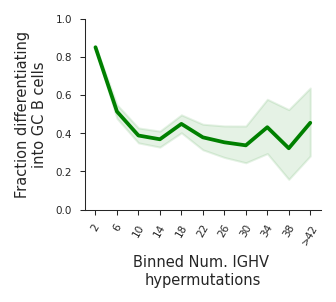

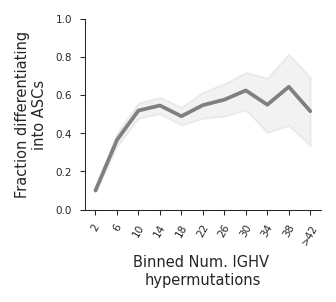

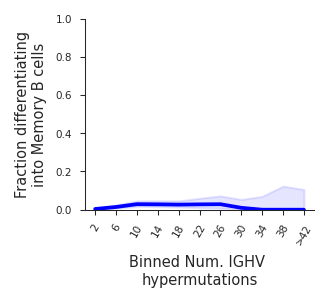

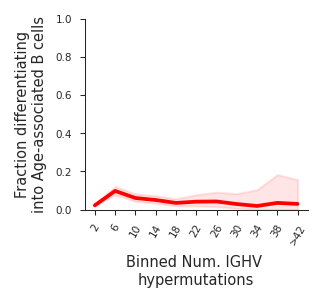

In [52]:
# function to calculate the fraction and confidence interval
def calculate_fraction_and_ci(group, celltype):
    count_celltype = (group['bcelltype'] == celltype).sum()
    n_total = len(group)
    fraction_celltype = count_celltype / n_total
    lower, upper = proportion_confint(count_celltype, n_total, alpha=0.05, method='beta')
    return pd.Series({f'fraction_{celltype}': fraction_celltype, 'lower_ci': lower, 'upper_ci': upper})

# List of cell types interested in
celltypes = ["GC B cells", "ASCs", "Memory B cells"]

# Dictionary to store color information for each cell type
celltypes_dict = {
    "GC B cells": 'green',
    "ASCs": 'grey',
    "Memory B cells": 'blue',
    "Age-associated B cells": 'red'
}

for celltype in celltypes_dict.keys():
    grouped = bcell_data.groupby(['bin', 'in_vitro_stim'])
    fractions_per_sample = grouped.apply(lambda group: calculate_fraction_and_ci(group, celltype)).reset_index()
    fractions_per_sample = fractions_per_sample[fractions_per_sample.in_vitro_stim == True]
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(2.25, 2))
    points_plot = sns.pointplot(data=fractions_per_sample, x='bin', y=f'fraction_{celltype}', errorbar=None, color=celltypes_dict[celltype], join=True)
    
    # Manually adjust the size of the points to 0
    for point in points_plot.collections:
        point.set_sizes([0])
    
    # Manually add the filled error bars using plt.fill_between
    x_values = range(len(fractions_per_sample))
    plt.fill_between(x_values, fractions_per_sample['lower_ci'], fractions_per_sample['upper_ci'], color=celltypes_dict[celltype], alpha=0.1)
    
    plt.xticks(rotation=60)
    plt.xlabel('Binned Num. IGHV \nhypermutations')
    plt.ylabel(f'Fraction differentiating\ninto {celltype}')
    plt.tight_layout()
    sns.despine()
    plt.ylim(0, 1)
    plt.gca().xaxis.set_minor_locator(NullLocator())
    plt.gca().yaxis.set_minor_locator(NullLocator())
    
    plt.show()
    save_figure(fig, f"v_mismatch_diff_chance_{celltype.replace(' ', '_')}")